In [1]:
import numpy as np
import pandas as pd
from copy import copy, deepcopy

import os
import json
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np

In [2]:
from ds_toolkit.file_io.json_utils import read_json

In [3]:
def task_summary(task):
    print("len of train task : ", len(task['train']))
    print("len of test task : ", len(task['test']))
    
    same_io_shape = True
    shapes = []
    for t in task['train']:
        input_shape, output_shape = (len(t['input']), len(t['input'][0])), (len(t['output']), len(t['output'][0]))
        shapes.append((input_shape, output_shape))
        if input_shape != output_shape:
            same_io_shape = False
    
    print("same io shape : ", same_io_shape)
    

def plot_grid_util(ax, grid):
    cmap = colors.ListedColormap([
        '#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
        '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'
    ])
    norm = colors.Normalize(vmin=0, vmax=9)
    ax.imshow(grid, cmap=cmap, norm=norm)
    ax.grid(True, which='both',color='lightgrey', linewidth=0.5)   

    ax.set_yticks([x-0.5 for x in range(1+len(grid))])
    ax.set_xticks([x-0.5 for x in range(1+len(grid[0]))])     
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    
def plot_grid(grid):
    fig, ax = plt.subplots()
    plot_grid_util(ax, grid)


def plot_pair(i, o):
    fig, (ax, ax2) = plt.subplots(1,2)
    plot_grid_util(ax, i)
    plot_grid_util(ax2, o)

In [4]:
class Grid:
    def __init__(self, grid):
        assert isinstance(grid, list), "grid should be list of list"
        assert isinstance(grid[0], list), "grid should be list of list"
        
        self.grid = grid
        self.row_len = len(grid)
        self.col_len = len(grid[0])
        
        self.set_cartesian_coords()
        self.set_edge_coords()
        self.set_block_coords()
        
    def set_edge_coords(self):
        self.edge_coords = []
        edge_v = [self.row_len - 1, self.col_len -1, 0]
        for c in self.coords:
            if c[0] in edge_v or c[1] in edge_v and not self.access(*c):
                self.edge_coords.append(c)
                
    def set_block_coords(self, val=3):
        self.block_coords = []
        for c in self.coords:
            if self.access(*c)==val:
                self.block_coords.append(c)

    def set_cartesian_coords(self):
        self.coords = []
        for r in range(self.row_len):
            for c in range(self.col_len):
                self.coords.append((r, c))
    
    def show_cart_coords(self):
        for r in range(self.row_len):
            for c in range(self.col_len):
                print("({}, {}) ".format(r, c), end="")
            print("\n")
            
    def get_dir_coord(self, coord, dir_):
        x, y = coord
        
        blocked = False
        if dir_=='N':
            x, blocked = (x - 1, blocked) if x > 0 else (x, True)
        elif dir_=='E':
            y, blocked = (y + 1, blocked) if y < self.col_len -1 else (y, True)
        elif dir_=='S':
            x, blocked = (x + 1, blocked) if x < self.row_len -1 else (x, True)
        elif dir_=='W':
            y, blocked = (y - 1, blocked) if y > 0 else (y, True)
        
        return (x, y), blocked
    
    def show(self):
        plot_grid(self.grid)
        
    def as_string(self):
        str_grid = ""
        for row in self.grid:
            for n in row:
                str_grid += "{} ".format(n)
            str_grid += "\n"
        return str_grid
    
    def access(self, i, j):
        return self.grid[i][j]
    
    def modify(self, i, j, val):
        self.grid[i][j] = val
    
    def __str__(self):
        return self.as_string()
    
    def __repr__(self):
        return self.as_string()


In [49]:
def potential_grids(gi):
    p_grid = ""
    vgi = deepcopy(gi)
    for coord in vgi.coords:

        vals = []
        for dir_ in ['N', 'E', 'S', 'W']:
            coord_, blocked = vgi.get_dir_coord(coord, dir_)
            val = vgi.access(*coord_)
            vals.append(val)

        if vgi.access(*coord):
            p_grid += "{} ".format(val)
        elif len(np.nonzero(vals)[0]) == 4:
            p_grid += "x "
            vgi.grid[coord[0]][coord[1]] = 4
        elif len(np.nonzero(vals)[0]) >= 2:
            p_grid += "p "
            vgi.grid[coord[0]][coord[1]] = 1
        elif len(np.nonzero(vals)[0]) < 2:
            p_grid += "_ "
    vgi.show()
    return vgi

def potential_grids_2(gi):
    vgi = deepcopy(gi)
    p_stack = []
    c_stack = []
    for coord in gi.coords:
        vals = []
        for dir_ in ['N', 'E', 'S', 'W']:
            coord_, blocked = gi.get_dir_coord(coord, dir_)
            val = gi.access(*coord_)
            vals.append(val)

        if gi.access(*coord):
            continue
        elif len(np.nonzero(vals)[0]) == 4:
            vgi.grid[coord[0]][coord[1]] = 4
            c_stack.append(coord)
            vgi.block_coords.append(coord)
        elif len(np.nonzero(vals)[0]) >= 2:
            vgi.grid[coord[0]][coord[1]] = 1
            p_stack.append(coord)
        
    vgi.show()
    print("potential spots : ", len(p_stack))
    print("confirmed spots : ", len(c_stack))
    return vgi, p_stack, c_stack

def finalize_grids(gi):
    vgi = deepcopy(gi)
    change = False
    for coord in vgi.coords:
        if vgi.access(*coord)==4:
            for dir_ in ['N', 'E', 'S', 'W']:
                coord_, blocked = vgi.get_dir_coord(coord, dir_)
                if vgi.access(*coord_)==1:
                    vgi.grid[coord_[0]][coord_[1]] = 4
                    
                    change = True
    if change:
        vgi = finalize_grids(vgi)
    else:
        ## clean up
        for coord in vgi.coords:
            if vgi.access(*coord)==1:
                vgi.grid[coord[0]][coord[1]] = 0
        vgi.show()
    
    return vgi

In [50]:
sample_task = read_json('./tasks/00d62c1b.json')
# plot_task(sample_task)

In [51]:
task_summary(sample_task)

len of train task :  5
len of test task :  1
same io shape :  True


In [52]:
# ind = 1

# i = sample_task['train'][ind]["input"]
# o = sample_task['train'][ind]["output"]

# plot_pair(i, o)


# gi = Grid(i)
# gi.show()
# vgi = potential_grids(gi)
# output = finalize_grids(vgi)
# plot_grid(o)

# output.grid == o

In [53]:
## find gvgirid with 2 neighbours
## travel from that gr

potential spots :  19
confirmed spots :  1


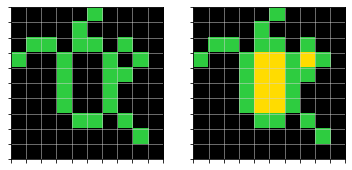

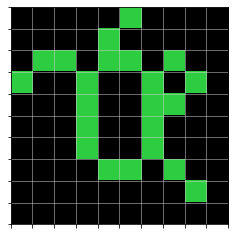

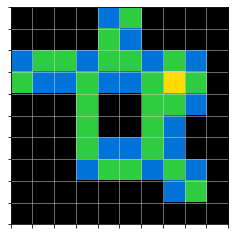

In [59]:
ind = 2

i = sample_task['train'][ind]["input"]
o = sample_task['train'][ind]["output"]

plot_pair(i, o)


gi = Grid(i)
gi.show()
vgi, p_stack, c_stack = potential_grids_2(gi)

In [64]:
gi.show_cart_coords()

(0, 0) (0, 1) (0, 2) (0, 3) (0, 4) (0, 5) (0, 6) (0, 7) (0, 8) (0, 9) 

(1, 0) (1, 1) (1, 2) (1, 3) (1, 4) (1, 5) (1, 6) (1, 7) (1, 8) (1, 9) 

(2, 0) (2, 1) (2, 2) (2, 3) (2, 4) (2, 5) (2, 6) (2, 7) (2, 8) (2, 9) 

(3, 0) (3, 1) (3, 2) (3, 3) (3, 4) (3, 5) (3, 6) (3, 7) (3, 8) (3, 9) 

(4, 0) (4, 1) (4, 2) (4, 3) (4, 4) (4, 5) (4, 6) (4, 7) (4, 8) (4, 9) 

(5, 0) (5, 1) (5, 2) (5, 3) (5, 4) (5, 5) (5, 6) (5, 7) (5, 8) (5, 9) 

(6, 0) (6, 1) (6, 2) (6, 3) (6, 4) (6, 5) (6, 6) (6, 7) (6, 8) (6, 9) 

(7, 0) (7, 1) (7, 2) (7, 3) (7, 4) (7, 5) (7, 6) (7, 7) (7, 8) (7, 9) 

(8, 0) (8, 1) (8, 2) (8, 3) (8, 4) (8, 5) (8, 6) (8, 7) (8, 8) (8, 9) 

(9, 0) (9, 1) (9, 2) (9, 3) (9, 4) (9, 5) (9, 6) (9, 7) (9, 8) (9, 9) 



In [60]:
len(p_stack)

19

In [61]:
len(gi.block_coords)

22

In [62]:
def modify_bulk(coords, gi, val):
    for c in coords:
        gi.modify(*c, val)

def finalize_grids(gi, p):
    visited = []
    visited.append(p)
    
    stop = False
    while not stop:
        print(p)
        new_coords = []
        for dir_ in ['N', 'E', 'S', 'W']:
            new_coord, _ = gi.get_dir_coord(p, dir_)
            new_coords.append(new_coord)
            if new_coord not in gi.block_coords:
                visited.append(new_coord)
        
        for new_coord in new_coords:
            if new_coord in gi.edge_coords:
                stop = True
                modify_bulk(visited, gi, 0)
            else:
                p = new_coord
    gi.show()
    return gi

(0, 4)
(1, 5)
(2, 0)
(2, 3)
(2, 2)
(2, 1)
(2, 6)
(2, 5)
(2, 4)
(2, 3)
(2, 2)
(2, 1)
(2, 8)
(3, 1)
(3, 0)
(3, 2)
(3, 1)
(3, 0)
(3, 4)
(3, 3)
(3, 2)
(3, 1)
(3, 0)
(3, 5)
(3, 4)
(3, 3)
(3, 2)
(3, 1)
(3, 0)
(4, 8)
(5, 7)
(5, 6)
(5, 5)
(5, 4)
(5, 3)
(5, 2)
(5, 1)
(6, 4)
(6, 3)
(6, 2)
(6, 1)
(6, 5)
(6, 4)
(6, 3)
(6, 2)
(6, 1)
(6, 7)
(6, 6)
(6, 5)
(6, 4)
(6, 3)
(6, 2)
(6, 1)
(7, 3)
(7, 2)
(7, 1)
(7, 6)
(7, 5)
(7, 4)
(7, 3)
(7, 2)
(7, 1)
(7, 8)
(8, 7)


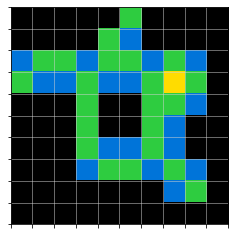

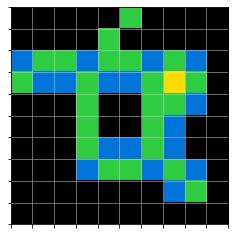

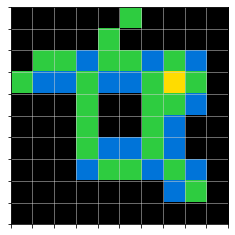

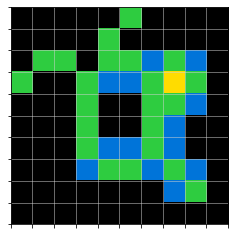

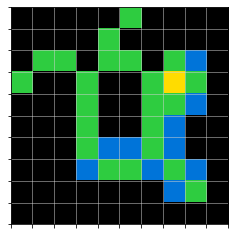

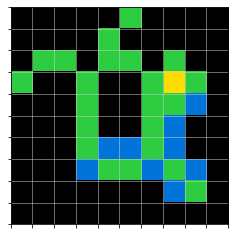

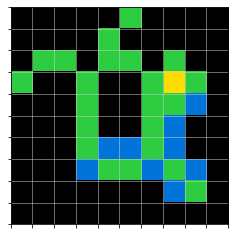

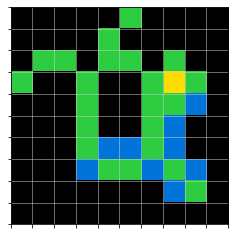

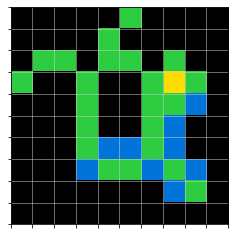

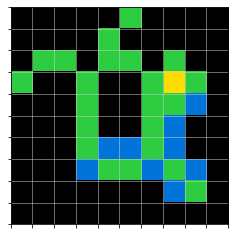

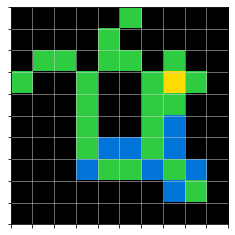

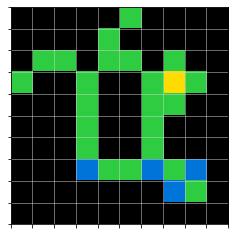

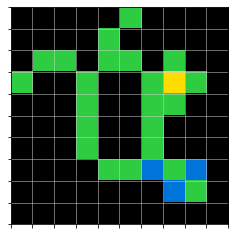

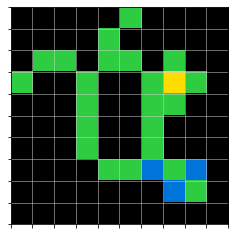

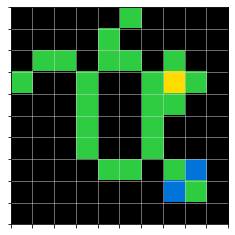

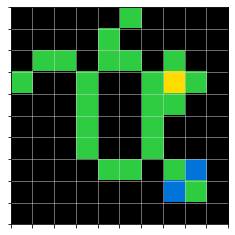

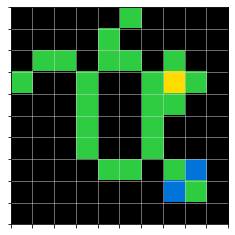

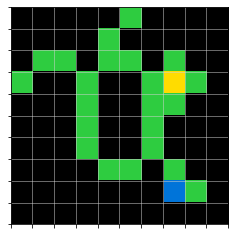

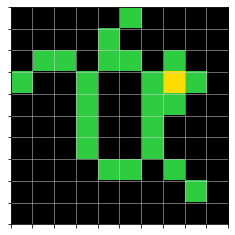

In [63]:
for p in p_stack:
    gi = finalize_grids(vgi, p)

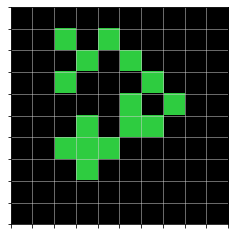

In [38]:
gi.show()

In [14]:
# finalize_grids(vgi, p_stack)

In [15]:
gi.grid

[[0, 0, 0, 0, 0, 0],
 [0, 0, 3, 0, 0, 0],
 [0, 3, 0, 3, 0, 0],
 [0, 0, 3, 0, 3, 0],
 [0, 0, 0, 3, 0, 0],
 [0, 0, 0, 0, 0, 0]]